In [66]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import plotly
from fbprophet import Prophet 
from sodapy import Socrata
from fbprophet.diagnostics import cross_validation 
from fbprophet.plot import plot_cross_validation_metric

## Load data from Seattle Crimes Website

In [26]:
#Download some data from the Seattle crime database using the Socrata API
#Set client
client = Socrata("data.seattle.gov", None)

#Simple for-loop to gather a few years of data from the API, which limits you to 1000 results per call without an 
#API token, and store results in a pandas DataFrame
results_df = pd.DataFrame()
for x in range(0, 5000, 1000):
    results = client.get("4fs7-3vj5", offset = x, where = "((occ_datetime > '2015-01-01T00:00:00.000') AND (occ_datetime < '2019-10-01T00:00:00.000')) AND ((crime_description = 'LIQUOR LAW VIOLATION') OR (crime_description = 'DUI-LIQUOR'))")
    results_df = pd.concat([results_df, pd.DataFrame.from_records(results)], axis = 0, ignore_index = True)

#Count number of crimes per day and reset column headers to names specific for Prophet
counts_df = pd.DataFrame(results_df.groupby('occ_datetime').size().reset_index(name='counts'))
counts_df = counts_df.rename(columns = {'occ_datetime': 'ds', 'counts': 'y'})

## Use Prophet to model daily alcohol-related crimes

Prophet uses the same style API as scikit-learn: instantiate the class object, fit the model, then predict!

In [57]:
#Instantiate the Prophet class
p = Prophet(holidays_prior_scale = 20)
#Add US holidays, since alcohol crimes spike near holidays (especially New Year!)
p.add_country_holidays('US')
#Fit the model 
p.fit(counts_df);

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


## Forecast into the future!

In [58]:
#Make a DataFrame with dates in the future using the helper function
future = p.make_future_dataframe(periods=365)

#Predict into the future (this step takes a little while)
forecast = p.predict(future)

In [59]:
#Check out a couple metrics of the predictions
forecast['yhat'].describe()

count    1803.000000
mean        3.016818
std         0.944940
min         0.621862
25%         2.247774
50%         2.806051
75%         3.850827
max         7.915260
Name: yhat, dtype: float64

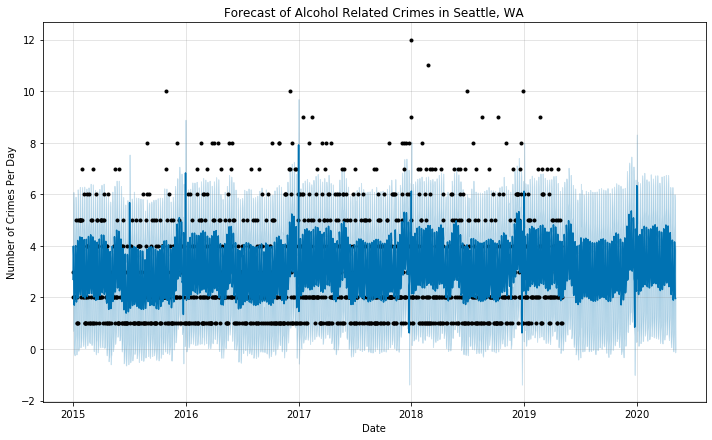

In [60]:
#Plot the data and predictions with their confidence intervals
fig1 = p.plot(forecast, xlabel = 'Date', ylabel = "Number of Crimes Per Day")
plt.title("Forecast of Alcohol Related Crimes in Seattle, WA");


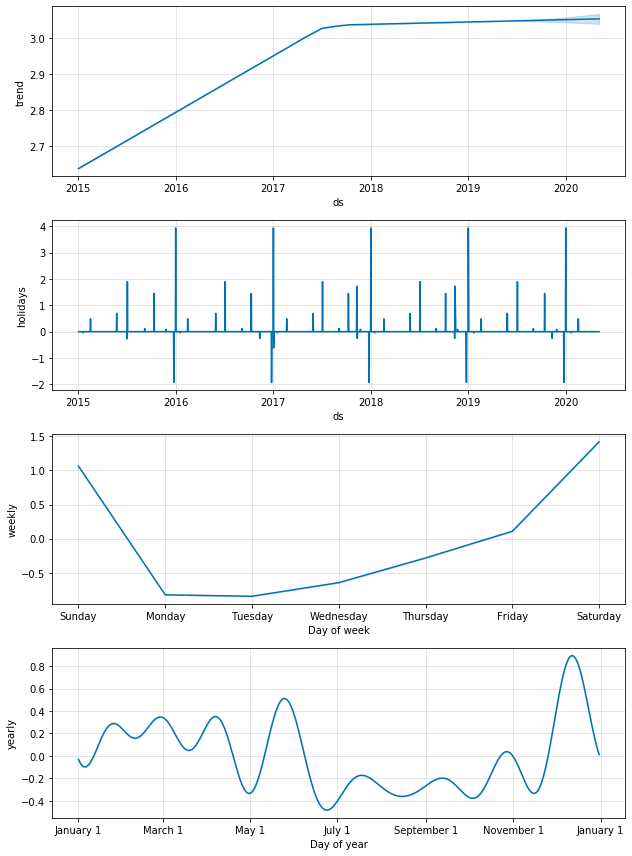

In [61]:
fig2 = p.plot_components(forecast)

In [62]:

df_cv = cross_validation(p, initial='1095 days', period='180 days', horizon = '365 days')
df_cv.head()

INFO:fbprophet:Making 1 forecasts with cutoffs between 2018-05-06 00:00:00 and 2018-05-06 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2018-05-07,2.014535,0.065053,3.957033,2,2018-05-06
1,2018-05-08,2.146498,0.075713,4.271258,2,2018-05-06
2,2018-05-09,2.304632,0.356856,4.479501,1,2018-05-06
3,2018-05-10,2.692713,0.748506,4.838329,6,2018-05-06
4,2018-05-11,3.186781,1.357795,5.271386,4,2018-05-06


In [63]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,coverage
0,36 days,2.619447,1.618471,1.195777,0.550942,0.75
1,38 days,2.619789,1.618576,1.198624,0.552365,0.75
2,39 days,2.678783,1.636699,1.237226,0.593256,0.75
3,40 days,2.673209,1.634995,1.235030,0.562130,0.75
4,41 days,2.467264,1.570753,1.196839,0.555765,0.75


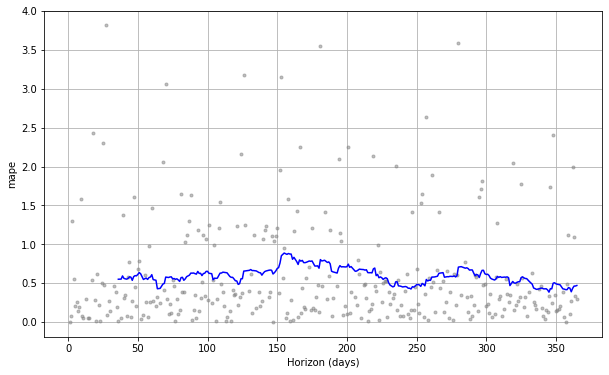

In [64]:

fig3 = plot_cross_validation_metric(df_cv, metric='mape')
